# Educe

[Educe][educe] is a library for working with a variety of discourse corpora.
This tutorial aims to show what using educe would be like.

## Installation

```shell
git clone https://github.com/kowey/educe.git
cd educe
pip install -r requirements.txt
```

Note: these instructions assume you are running within
a [virtual environment][virtualenv].
If not, and if you have permission
denied errors, replace `pip` with `sudo pip`.

## Tutorial setup

RST-DT portions of this tutorial require that you have a local copy of the RST Discourse Treebank. For purposes of this tutorial, you will need to link this into the data directory, for example

```
ln -s $HOME/CORPORA/rst_discourse_treebank data
ln -s $HOME/CORPORA/PTBIII data
```
### Tutorial in browser (optional)

This tutorial can either be followed along with the command line and your favourite
text editor, or embedded in an interactive webpage via iPython:

```shell
pip install ipython
cd tutorials
ipython notebook
```

[educe]: http://kowey.github.io/educe
[virtualenv]: http://virtualenv.readthedocs.org/en/latest/


## Reading corpus files (RST-DT)

In [17]:
from __future__ import print_function
import educe.rst_dt

# relative to the educe docs directory
data_dir = '../data'
rst_corpus_dir = '{dd}/rst_discourse_treebank/data/RSTtrees-WSJ-double-1.0/'.format(dd=data_dir)

# read and load the documents from the WSJ which were double-tagged
rst_reader = educe.rst_dt.Reader(rst_corpus_dir)
rst_corpus = rst_reader.slurp(verbose=True)

# print a text fragment from the first ten files we read
for key in rst_corpus.keys()[:10]:
    doc = rst_corpus[key]
    print("{0}: {1}".format(key.doc, doc.text()[:50]))

Slurping corpus dir [51/53]

wsj_1365.out: The Justice Department has revised certain interna
wsj_0633.out: These are the last words Abbie Hoffman ever uttere
wsj_1105.out: CHICAGO - Sears, Roebuck & Co. is struggling as it
wsj_1168.out: Wang Laboratories Inc. has sold $25 million of ass
wsj_1100.out: Westinghouse Electric Corp. said it will buy Shaw-
wsj_1924.out: CALIFORNIA STRUGGLED with the aftermath of a Bay a
wsj_0669.out: Nissan Motor Co. expects net income to reach 120 b
wsj_0651.out: Nelson Holdings International Ltd. shareholders ap
wsj_2309.out: Atco Ltd. said its utilities arm is considering bu
wsj_1120.out: Japan has climbed up from the ashes of World War I


Slurping corpus dir [53/53 done]


### Faster reading

If you know that you only want to work with a subset of the corpus files, you can pre-filter the corpus before reading the files. 

It helps to know here that an educe corpus is a mapping from [file id keys](https://educe.readthedocs.org/en/latest/api-doc/educe.html#educe.corpus.FileId) to documents.  The FileId contains the minimally identifying
metadata for a document, for example, the document name, or its annotator. 
For RST-DT, only the `doc` attribute is used. 

In [18]:
rst_subset = rst_reader.filter(rst_reader.files(), 
                               lambda k:k.doc.startswith("wsj_062"))
rst_corpus_subset = rst_reader.slurp(rst_subset, verbose=True)
for key in rst_corpus_subset:
    doc = rst_corpus_subset[key]
    print("{0}: {1}".format(key.doc, doc.text()[:50]))

wsj_0627.out: October employment data -- also could turn out to 
wsj_0624.out: Costa Rica reached an agreement with its creditor 


Slurping corpus dir [2/2 done]


## Trees and annotations

RST DT documents are basically trees

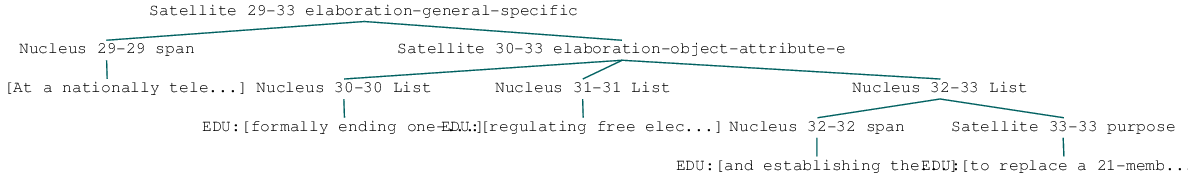

In [19]:
from educe.corpus import FileId
# an (ex)ample document
ex_key = educe.rst_dt.mk_key("wsj_1924.out")
ex_doc = rst_corpus[ex_key] # pick a document from the corpus

# display PNG tree
from IPython.display import display
ex_subtree = ex_doc[2][0][0][1] # navigate down to a small subtree
display(ex_subtree) # NLTK > 3.0b1 2013-07-11 should display a PNG image of the RST tree
# Mac users: see note below

Note for Mac users following along in iPython: if displaying the tree above does not work (particularly if you see a GS prompt in your iPython terminal window instead of an embedded PNG in your browser), try my [NLTK patch](https://github.com/kowey/nltk/commit/4ac4beacff7f9363c84e5d72719e2b5cda8267f2) from 2014-09-17. 

### Standing off

RST DT trees function both as NLTK trees, and as [educe standoff annotations][standoff]. Most annotations in educe can be seen as standoff annotations in some sense; they (perhaps indirectly) extend `educe.annotation.Standoff` and provide a `text_span()` function. Comparing annotations usually consists of comparing their text spans.

Text spans in the RST DT corpus refer to the source document beneath each tree file, eg. for the tree file `wsj_1111.out.dis`, educe reads `wsj_1111.out` as its source text. (The source text is somewhat optional as the RST trees themselves contain text, but this tends to have subtle differences with its underlying source).  Below, we see an example of one of these source documents.

[standoff]: http://educe.readthedocs.org/en/latest/api-doc/educe.html#educe.annotation.Standoff

In [20]:
ex_rst_txt_filename = '{corpus}/{doc}'.format(corpus=rst_corpus_dir,
                                              doc=ex_key.doc)

with open(ex_rst_txt_filename) as ifile:
    ex_txt = ifile.read()
    ex_snippet_start = ex_txt.find("At a national")
    print(ex_txt[ex_snippet_start:ex_snippet_start + 500])

At a nationally televised legislative session in Budapest, the Parliament overwhelmingly approved changes formally ending one-party domination in the country, regulating free elections by next summer and establishing the office of state president to replace a 21-member council.
The country was renamed the Republic of Hungary.
Like other Soviet bloc nations, it had been known as a "people's republic" since 

The voting for new laws followed dissolution of Hungary's Communist Party this month and 


Now let's have a closer look at the annotations themselves.

In [21]:
# it may be useful to have a couple of helper functions to
# display standoff annotations in a generic way
def text_snippet(text):
    "short text fragment"
    if len(text) < 43:
        return text
    else:
        return "{0}...{1}".format(text[:20], text[-20:])

def preview_standoff(tystr, context, anno):
    "simple glimpse at a standoff annotation"
    span = anno.text_span()
    text = context.text(span)
    return "{tystr} at {span}:\t{snippet}".format(tystr=tystr,
                                                 span=span,
                                                 snippet=text_snippet(text))

### EDUs and subtrees

In [22]:
# in educe RST/DT all annotations have a shared context object
# that refers to an RST document; you don't always need to use
# it, but it can be handy for writing general code like the
# above
ex_context = ex_doc.label().context

# display some edus
print("Some edus")
edus = ex_subtree.leaves()
for edu in edus:
    print(preview_standoff("EDU", ex_context, edu))
    
print("\nSome subtrees")
# display some RST subtrees and the edus they enclose
for subtree in ex_subtree.subtrees():
    node = subtree.label()
    stat = "N" if node.is_nucleus() else "S"
    label = "{stat} {rel: <30}".format(stat=stat,
                                  rel=node.rel)
    print(preview_standoff(label, ex_context, subtree))

Some edus
EDU at (1504,1609):	At a nationally tele...gly approved changes
EDU at (1610,1662):	formally ending one-...tion in the country,
EDU at (1663,1703):	regulating free elections by next summer
EDU at (1704,1750):	and establishing the...e of state president
EDU at (1751,1782):	to replace a 21-member council.

Some subtrees
S elaboration-general-specific   at (1504,1782):	At a nationally tele...a 21-member council.
N span                           at (1504,1609):	At a nationally tele...gly approved changes
S elaboration-object-attribute-e at (1610,1782):	formally ending one-...a 21-member council.
N List                           at (1610,1662):	formally ending one-...tion in the country,
N List                           at (1663,1703):	regulating free elections by next summer
N List                           at (1704,1782):	and establishing the...a 21-member council.
N span                           at (1704,1750):	and establishing the...e of state president
S purpose             

### Paragraphs and sentences

Going back to the source text, we can notice that it seems to be divided into sentences and paragraphs with line separators.  This does not seem to be done very consistently, and in any case, RST constituents seem to traverse these boundaries freely.  But they can still make for useful standoff annotations.

In [23]:
for para in ex_context.paragraphs[4:8]:
    print(preview_standoff("paragraph", ex_context, para))
    for sent in para.sentences:
        print("\t" + preview_standoff("sentence", ex_context, sent))

paragraph at (862,1288):	The 77-year-old offi...o-democracy groups. 
	sentence at (862,1029):	The 77-year-old offi...ttee in East Berlin.
	sentence at (1030,1144):	Honecker, who was re... for health reasons.
	sentence at (1145,1288):	He was succeeded by ...o-democracy groups. 
paragraph at (1290,1432):	Honecker's departure...nted with his rule. 
	sentence at (1290,1432):	Honecker's departure...nted with his rule. 
paragraph at (1434,1502):	HUNGARY ADOPTED cons... democratic system. 
	sentence at (1434,1502):	HUNGARY ADOPTED cons... democratic system. 
paragraph at (1504,1913):	At a nationally tele...e's republic" since 
	sentence at (1504,1782):	At a nationally tele...a 21-member council.
	sentence at (1783,1831):	The country was rena...Republic of Hungary.
	sentence at (1832,1913):	Like other Soviet bl...e's republic" since 


## Penn Treebank integration

RST DT annotations are mostly over Wall Street Journal articles from the Penn Treebank. If you have a copy of the latter at the ready, you can ask educe to read and align the two (ie. PTB annotations treated as standing off the RST source text).  This alignment consists of some universal substitutions (eg. `-LBR-` to `(`) and with a [bit of hardcoding][ugh] to account for seemingly random differences in whitespace/punctuation.

[ugh]: https://github.com/kowey/educe/blob/master/educe/rst_dt/ptb.py


In [24]:
from educe.rst_dt import ptb
from nltk.tree import Tree

# confusingly, this is not an educe corpus reader, but the NLTK
# bracketed reader.  Sorry
ptb_reader = ptb.reader('{dd}/PTBIII/parsed/mrg/wsj/'.format(dd=data_dir))
ptb_trees = {}
for key in rst_corpus:
    ptb_trees[key] = ptb.parse_trees(rst_corpus, key, ptb_reader)

# pick and display an arbitary ptb tree
ex0_ptb_tree = ptb_trees[rst_corpus.keys()[0]][0]
print(ex0_ptb_tree.pprint()[:400])

(S
  (NP-SBJ
    (DT <educe.external.postag.Token object at 0x10e41ecd0>)
    (NNP <educe.external.postag.Token object at 0x10e41ee10>)
    (NNP <educe.external.postag.Token object at 0x10e41ef50>))
  (VP
    (VBZ <educe.external.postag.Token object at 0x10e41efd0>)
    (VP
      (VP
        (VBN <educe.external.postag.Token object at 0x10e41ef90>)
        (NP
          (JJ <educe.external.postag.


The result of this alignment is an educe `ConstituencyTree`, the leaves of which are educe `Token` objects.  We'll say a little bit more about these below.

In [25]:
# show what's beneath these educe tokens
def str_tree(tree):
    if isinstance(tree, Tree):
        return Tree(str(tree.label()), map(str_tree, tree))
    else:
        return str(tree)

print(str_tree(ex0_ptb_tree).pprint()[:400])

(S
  (NP-SBJ
    (DT The/DT	(0,3))
    (NNP Justice/NNP	(4,11))
    (NNP Department/NNP	(12,22)))
  (VP
    (VBZ has/VBZ	(23,26))
    (VP
      (VP
        (VBN revised/VBN	(27,34))
        (NP
          (JJ certain/JJ	(35,42))
          (JJ internal/JJ	(43,51))
          (NNS guidelines/NNS	(52,62))))
      (CC and/CC	(63,66))
      (VP (VBN clarified/VBN	(67,76)) (NP (NNS others/NNS	(77,83))))
 


## Combining annotations

We now have several types of annotation at our disposal:

* EDUs and RST trees
* raw text paragraph/sentences (not terribly reliable)
* PTB trees

The next question that arises is how we can use these annotations in conjuction with each other.

### Span enclosure and overlapping

The simplest way to reason about annotations (particularly since they tend to be sloppy and to overlap).  Suppose for example, we wanted to find all of the edus in a tree that are in the same sentence as an given edu. 

In [26]:
from itertools import chain

# pick an EDU, any edu
ex_edus = ex_subtree.leaves()
ex_edu0 = ex_edus[3]
print(preview_standoff('example EDU', ex_context, ex_edu0))

# all of the sentences in the example document
ex_sents = list(chain.from_iterable(x.sentences for x in ex_context.paragraphs))

# sentences that overlap the edu
# (we use overlaps instead of encloses because edus might
# span sentence boundaries)
ex_edu0_sents = [x for x in ex_sents if x.overlaps(ex_edu0)]

# and now the edus that overlap those sentences
ex_edu0_buddies = []
for sent in ex_edu0_sents:
    print(preview_standoff('overlapping sentence', ex_context, sent))
    buddies = [x for x in ex_edus if x.overlaps(sent)]
    buddies.remove(ex_edu0)
    for edu in buddies:
        print(preview_standoff('\tnearby EDU', ex_context, edu))
    ex_edu0_buddies.extend(buddies)

example EDU at (1704,1750):	and establishing the...e of state president
overlapping sentence at (1504,1782):	At a nationally tele...a 21-member council.
	nearby EDU at (1504,1609):	At a nationally tele...gly approved changes
	nearby EDU at (1610,1662):	formally ending one-...tion in the country,
	nearby EDU at (1663,1703):	regulating free elections by next summer
	nearby EDU at (1751,1782):	to replace a 21-member council.


### Span example 2 (exercise)

As an exercise, how about extracting the PTB part of speech tags for every token in our example EDU?  How for example, would you determine if an EDU contains a VBG-tagged word?

In [27]:
ex_postags = list(chain.from_iterable(t.leaves() for t in ptb_trees[ex_key]))

print("some of the POS tags")
for postag in ex_postags[300:310]:
    print(preview_standoff(postag.tag, ex_context, postag))
    
print()
ex_edu0_postags = [] # EXERCISE <-- fill this in
print("has VBG? ", ) # EXERCISE <-- fill this in

some of the POS tags
VBG at (1663,1673):	regulating
JJ at (1674,1678):	free
NNS at (1679,1688):	elections
IN at (1689,1691):	by
JJ at (1692,1696):	next
NN at (1697,1703):	summer
CC at (1704,1707):	and
VBG at (1708,1720):	establishing
DT at (1721,1724):	the
NN at (1725,1731):	office

has VBG? 


### Tree searching

The same span enclosure logic can be used to search parse trees for particular constituents, verb phrases. Alternatively, you can use the the `topdown` method provided by educe trees. This returns just the largest constituent for which some predicate is true.  It optionally accepts an additional argument to cut off the search when it is clearly out of bounds.

ptb tree at (1504,1782):	At a nationally tele...a 21-member council.
CC at (1704,1707):	and
VBG at (1708,1720):	establishing
NP at (1721,1731):	the office
PP at (1732,1750):	of state president
WHNP-1 at (1750,1750):	
NP-SBJ at (1750,1750):	


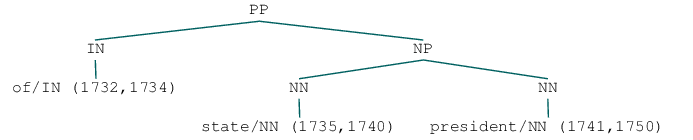

In [28]:
ex_ptb_trees = ptb_trees[ex_key]
ex_edu0_ptb_trees = [x for x in ex_ptb_trees if x.overlaps(ex_edu0)]
ex_edu0_cons = []
for ptree in ex_edu0_ptb_trees:
    print(preview_standoff('ptb tree', ex_context, ptree))
    ex_edu0_cons.extend(ptree.topdown(lambda c: ex_edu0.encloses(c)))
    
# the largest constituents enclosed by this edu
for cons in ex_edu0_cons:
    print(preview_standoff(cons.label(), ex_context, cons))
    
display(ex_edu0_cons[3])

## Simplified trees

The tree representation used in the RST DT can take some getting used to (relation labels are placed on the satellite rather than the root of a subtree). You may prefer to work with the simplified representation instead.  In the simple representation, trees are binarised and relation labels are moved to the root node.  Compare for example, the two versions of the same RST subtree.

Corpus representation




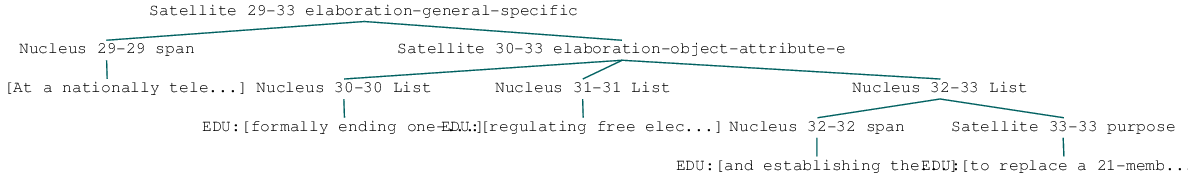

Simplified (binarised, rotated) representation




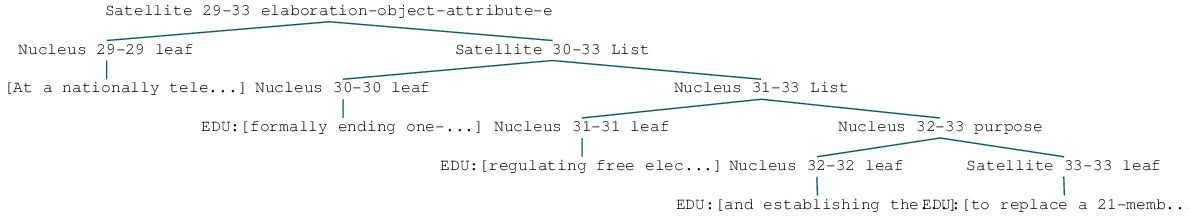

In [29]:
# rearrange the tree so that it is easier to work with
ex_simple_subtree = educe.rst_dt.SimpleRSTTree.from_rst_tree(ex_subtree)
print('Corpus representation\n\n')
display(ex_subtree)
print('Simplified (binarised, rotated) representation\n\n')
display(ex_simple_subtree)

## Dependency trees and back

Educe also provides an experimental conversion between simplified trees above and dependency trees.  See the [educe.rst_dt.deptree](https://educe.readthedocs.org/en/latest/api-doc/educe.rst_dt.html#module-educe.rst_dt.deptree) for the algorithm used.

Our current example is a little too small to give a sense of what the resulting dependency tree might look like, so we'll back up slightly closer to the root to have a wider view.

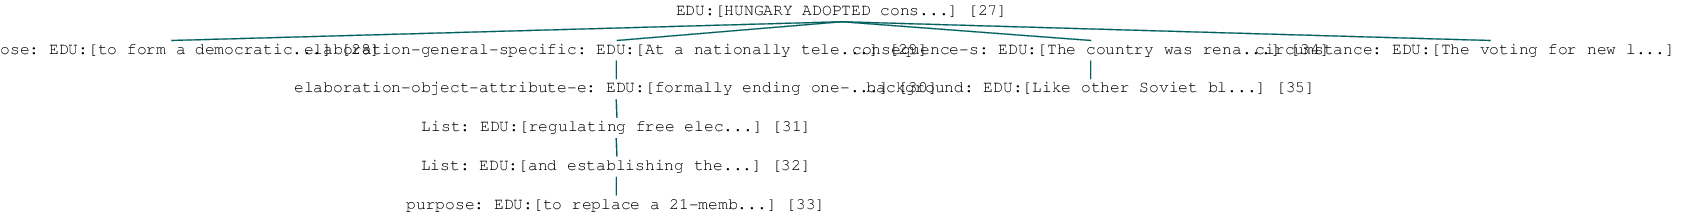

In [30]:
from educe.rst_dt import deptree

ex_subtree2 = ex_doc[2]
ex_simple_subtree2 = educe.rst_dt.SimpleRSTTree.from_rst_tree(ex_subtree2)
ex_deptree2 = deptree.relaxed_nuclearity_to_deptree(ex_simple_subtree2)
display(ex_deptree2)

Going back to our original example, we can (lossily) convert back from these dependency tree representations to RST trees. The dependency trees have some ambiguities in them that we can't resolve without an oracle, but we can at least make some guesses.  Note that when converting back to RST, we need to supply a list of relation labels that should be treated as multinuclear.

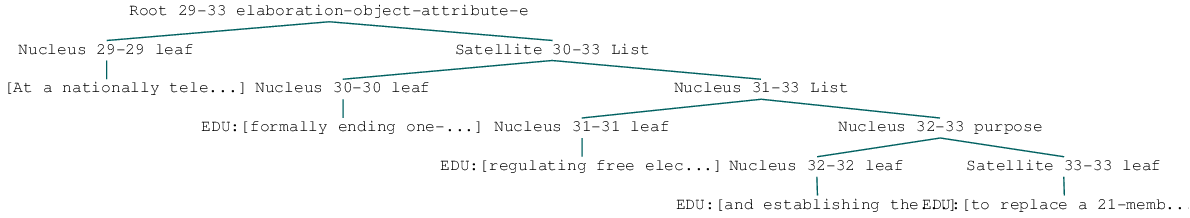

In [31]:
ex_deptree = deptree.relaxed_nuclearity_to_deptree(ex_simple_subtree)
ex_from_deptree = deptree.relaxed_nuclearity_from_deptree(ex_deptree, ["list"]) # multinuclear in lowercase
display(ex_from_deptree)

## Conclusion

In this tutorial, we've explored a couple of basic educe concepts, which we hope will enable you to extract some data from your discourse corpora, namely

* reading corpus data (and pre-filtering)
* standoff annotations
* searching by span enclosure, overlapping
* working with trees
* combining annotations from different sources

The concepts above should transfer to whatever discourse corpus you are working with (that educe supports, or that you are prepared to supply a reader for).

That said, some of the features mentioned in particular tutorial are specific to the RST DT:

* simplifying RST trees
* converting them to dependency trees
* PTB integration

This tutorial was last updated on 2014-09-18.
Educe is a bit of a moving target, so [let me know](https://github.com/kowey/educe/issues) if you run into any trouble!

### See also

#### rst-dt-util

Some of the things you may want to do with the RST DT may already exist in the rst-dt-util command line tool.  See `rst-dt-util --help` for more details.

(At the time of this writing the only really useful tool is the rst-dt-util reltypes one, which prints an inventory of relation labels, but the utility may grow over time)

#### External tool support

Educe has some support for reading data from outside the discourse corpus proper.  For example, if you run the stanford corenlp parser on the raw text, you can read them back into educe-style `ConstituencyTree` and `DependencyTree` annotations. See [educe.external](https://educe.readthedocs.org/en/latest/api-doc/educe.external.html) for details.

If you have a part of speech tagger that you would like to use, the `educe.external.postag` module may be useful for representing the annotations that come out of it

You can also add support for your own tools by creating annotations that extend `Standoff`, directly or otherwise.